# **Imports**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('AirQualityUCI.csv',sep=';')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


# **Check NaNs and columns**

In [3]:
df.isna().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [4]:
df = df.drop(columns=['Unnamed: 15','Unnamed: 16']).dropna()
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [5]:
df['Date_Time'] = pd.to_datetime(df.Date+' '+df.Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date','Time','Date_Time'], axis=1)
data.index = df.Date_Time
data = data.replace(',','.', regex=True).astype(float)

# **Missing values treatment imputing previous value for each column**

In [6]:
cols = data.columns
for j in cols:
    for i in range(0,len(data)):
       if data[j][i] == -200:
           data[j][i] = data[j][i-1]

# **Checking stationnarity using Johansen test, fit VAR and forecast next step**

In [7]:
johan_test_temp = data.drop(['CO(GT)'], axis=1)
print(coint_johansen(johan_test_temp,-1,1).eig)

#creating the train and validation set
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]
#fit the model
model = VAR(endog=train)
model_fit = model.fit()
# make prediction on validation
prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

#make final predictions
model = VAR(endog=data)
model_fit = model.fit()
num_steps_forecast = 10
yhat = model_fit.forecast(model_fit.endog, steps=num_steps_forecast)

[1.75510896e-01 1.52389933e-01 1.15120416e-01 1.04126281e-01
 9.29485509e-02 6.89397159e-02 5.77070988e-02 3.43554214e-02
 3.05980659e-02 1.18697142e-02 2.46766099e-03 7.09584856e-05]


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


rmse value for CO(GT) is :  1.408688883687264
rmse value for PT08.S1(CO) is :  205.8955828402142
rmse value for NMHC(GT) is :  6.673548711338459
rmse value for C6H6(GT) is :  7.1300872487061735
rmse value for PT08.S2(NMHC) is :  277.8484437680232
rmse value for NOx(GT) is :  214.7832234091289
rmse value for PT08.S3(NOx) is :  244.95769661934858
rmse value for NO2(GT) is :  66.69695211710682
rmse value for PT08.S4(NO2) is :  490.0838893412018
rmse value for PT08.S5(O3) is :  446.51541648881613
rmse value for T is :  10.72132579560943
rmse value for RH is :  17.111676248172948
rmse value for AH is :  0.5216247245188741


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


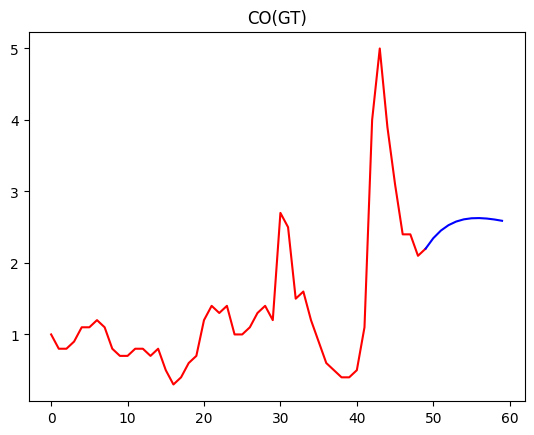

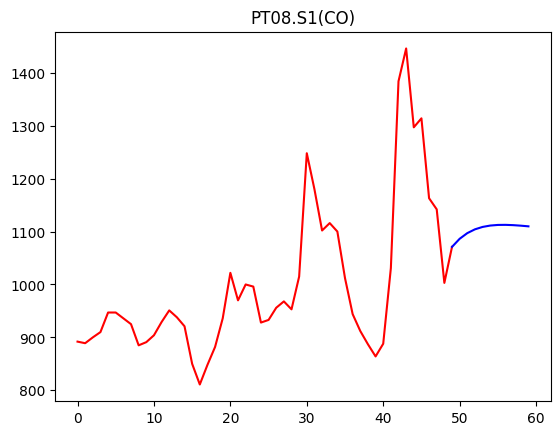

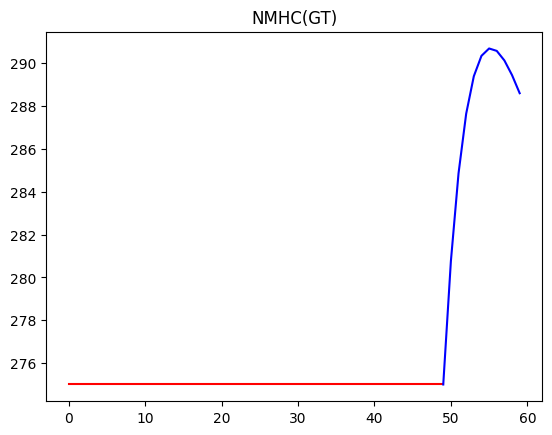

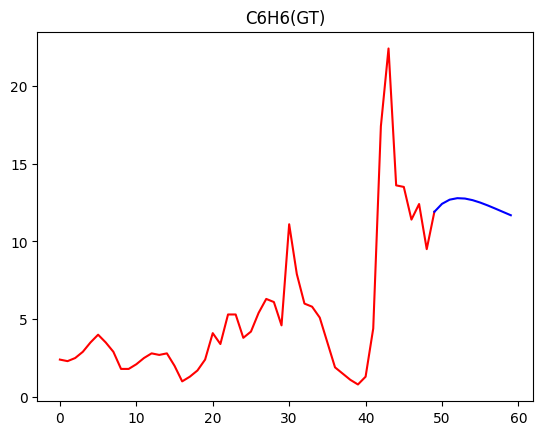

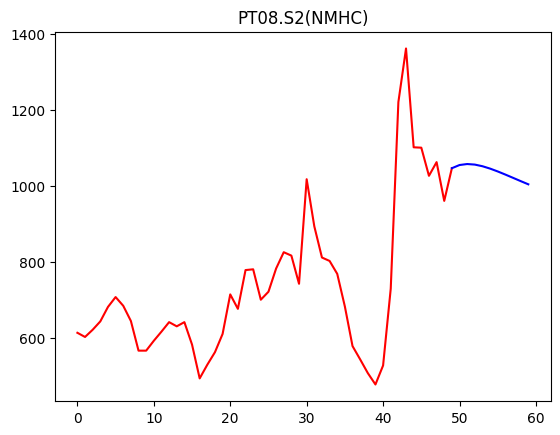

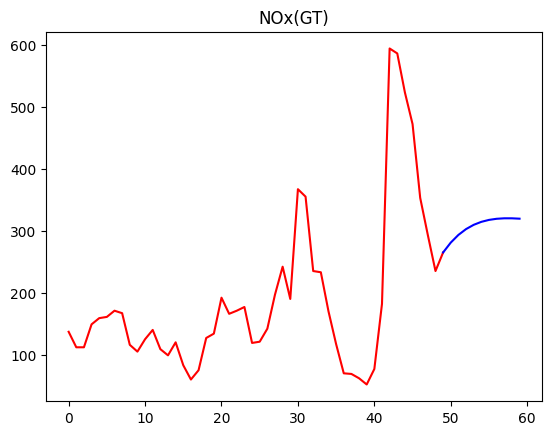

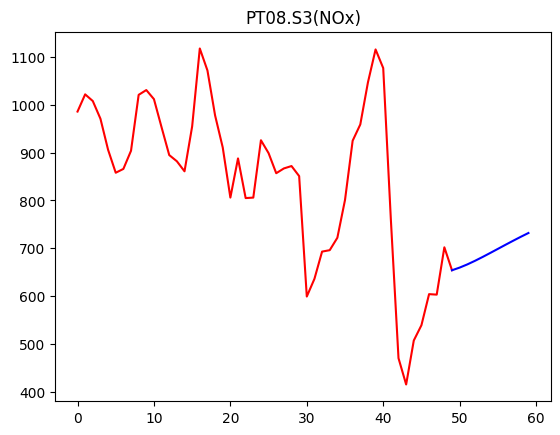

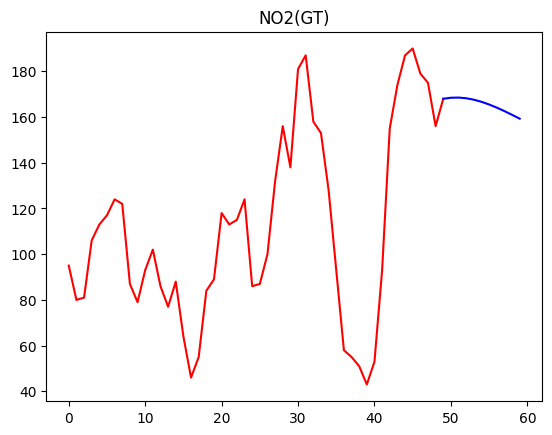

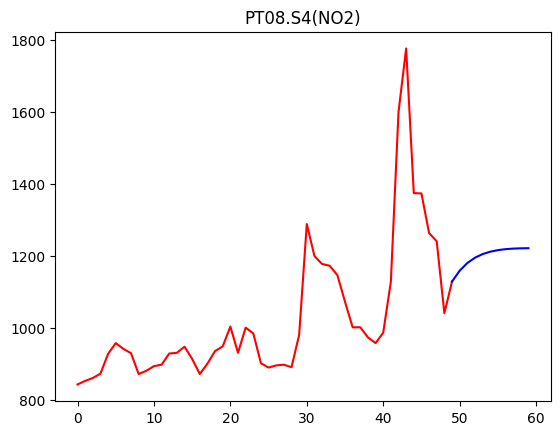

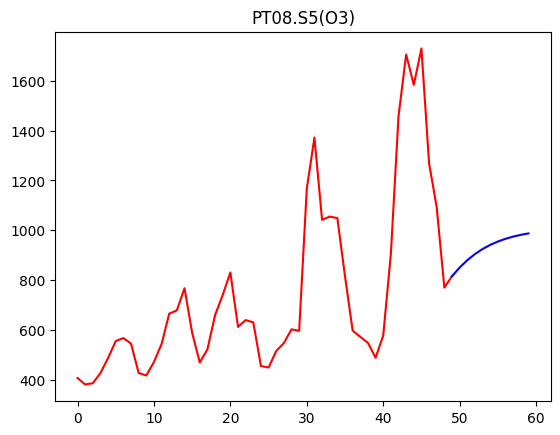

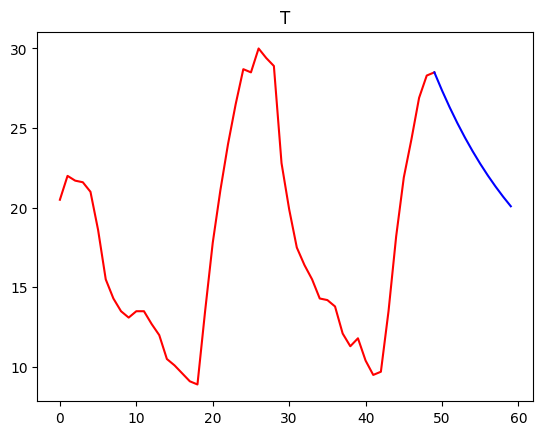

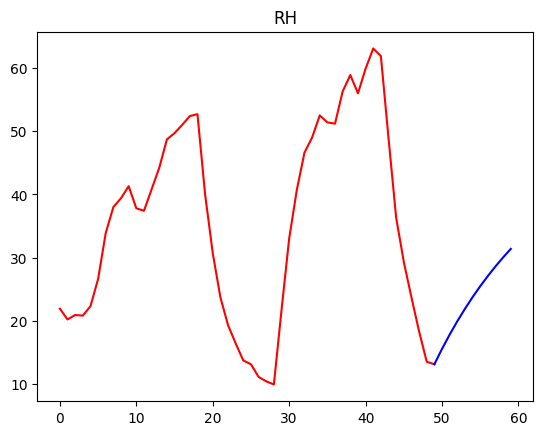

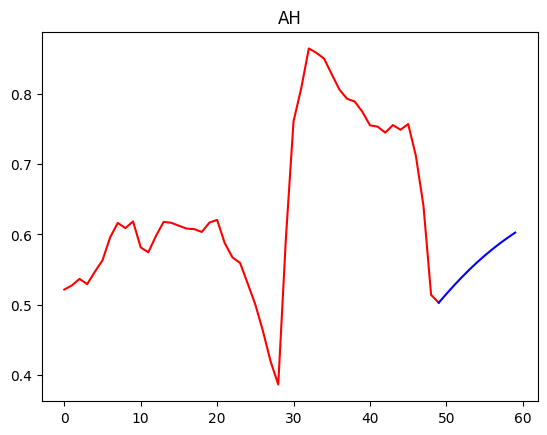

In [8]:
for i in range(len(cols)):
  plt.title(cols[i])
  data_plotted = list(data[cols[i]][-50:])
  predicted_plot = []
  for j in range(num_steps_forecast):
    predicted_plot.append(yhat[j][i])
  plt.plot(list(range(50)),data_plotted, "r-")
  plt.plot(list(range(49,50+num_steps_forecast)),[data_plotted[-1]]+predicted_plot,color='blue')
  plt.pause(0.0001)

# **Test with scaling**

In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
print(coint_johansen(data_scaled,-1,1).eig)

#creating the train and validation set
train_scaled = data_scaled[:int(0.8*(len(data_scaled)))]
valid_scaled =  scaler.inverse_transform(data_scaled[int(0.8*(len(data_scaled))):])
#fit the model
model_scaled = VAR(endog=train_scaled)
model_scaled_fit = model_scaled.fit()
# make prediction on validation
predictions_scaled =  scaler.inverse_transform(model_scaled_fit.forecast(model_scaled_fit.endog, steps=len(valid_scaled)))

#converting predictions to dataframe
predictions_scaled_df = pd.DataFrame(index=range(0,len(predictions_scaled)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(predictions_scaled)):
       predictions_scaled_df.iloc[i][j] = predictions_scaled[i][j]

#check rmse
for i in range(len(cols)):
    print('rmse value for', cols[i], 'is : ', np.sqrt(mean_squared_error(predictions_scaled[i], valid_scaled[i])))

# Make final predictions
model_scaled = VAR(endog=data_scaled)
model_scaled_fit = model_scaled.fit()
num_steps_forecast = 10
yhat = scaler.inverse_transform(model_scaled_fit.forecast(model_scaled_fit.endog, steps=num_steps_forecast))

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/vector_ar/vecm.py:648: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn(


[1.88114070e-01 1.58823434e-01 1.16304449e-01 1.07027122e-01
 9.49183432e-02 7.04789133e-02 6.48625254e-02 5.31038335e-02
 3.68940148e-02 3.01347447e-02 1.02303566e-02 3.39539712e-03
 1.19279344e-04]
rmse value for CO(GT) is :  25.845025458835263
rmse value for PT08.S1(CO) is :  22.129426065740613
rmse value for NMHC(GT) is :  20.864380053878058
rmse value for C6H6(GT) is :  21.25628595801095
rmse value for PT08.S2(NMHC) is :  101.08862440199118
rmse value for NOx(GT) is :  101.30647101388648
rmse value for PT08.S3(NOx) is :  42.22870719222333
rmse value for NO2(GT) is :  59.38145416053712
rmse value for PT08.S4(NO2) is :  43.95540095253932
rmse value for PT08.S5(O3) is :  77.72330374254223
rmse value for T is :  103.35841412545133
rmse value for RH is :  111.30966033586135
rmse value for AH is :  172.5410894147322


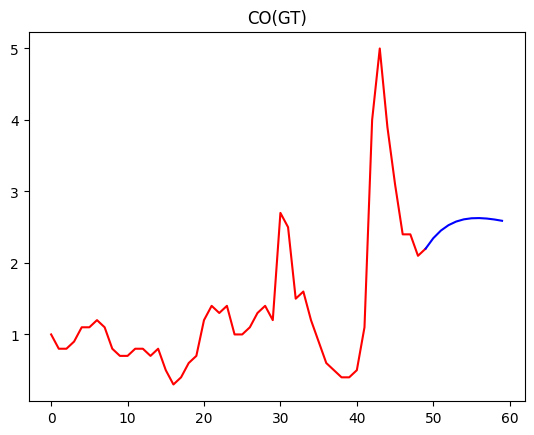

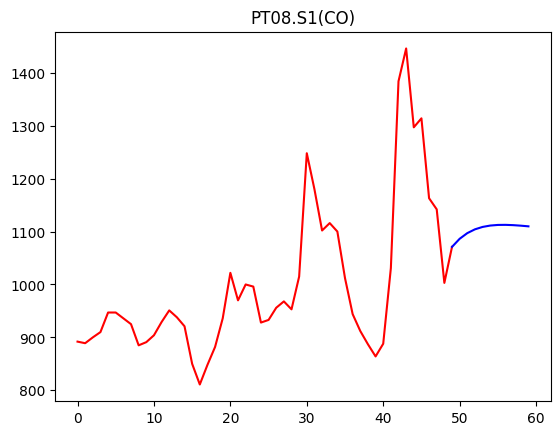

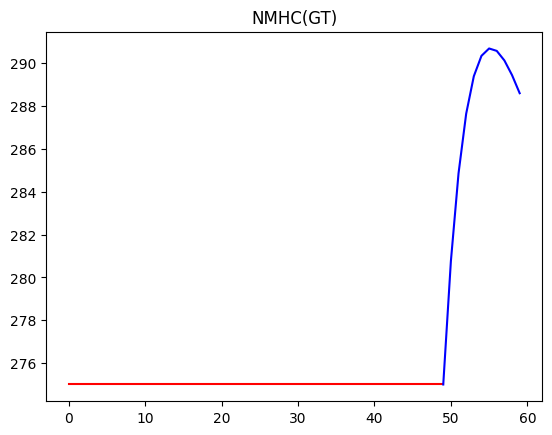

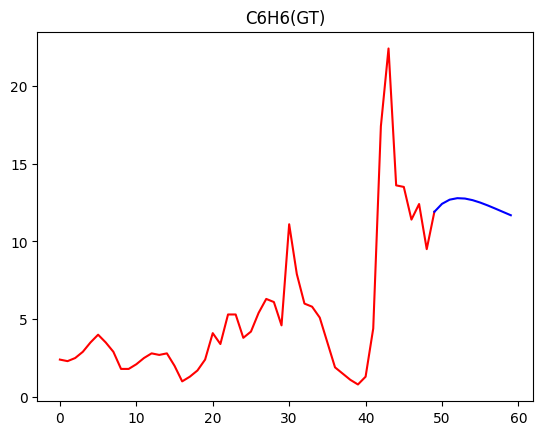

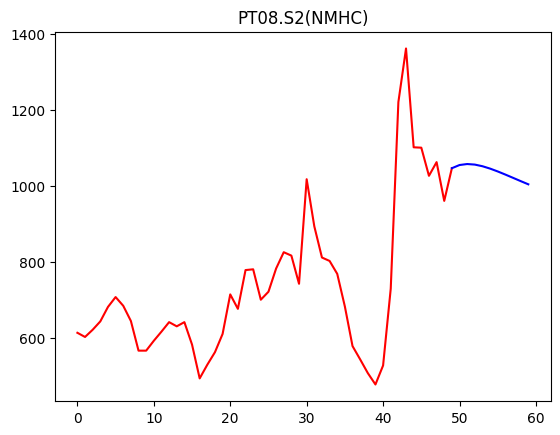

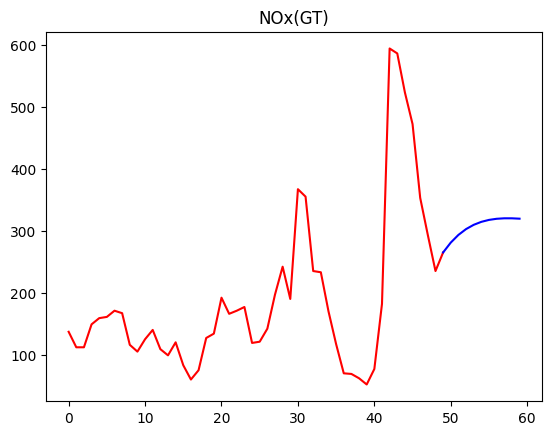

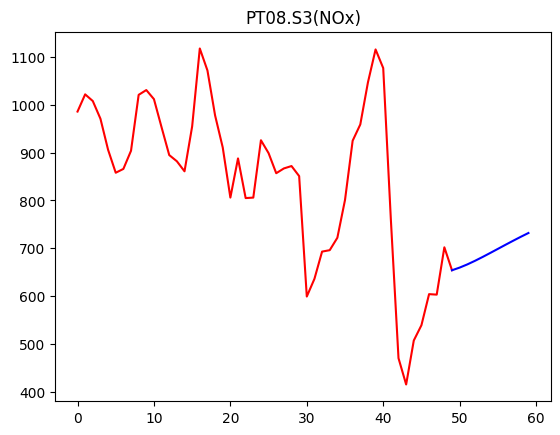

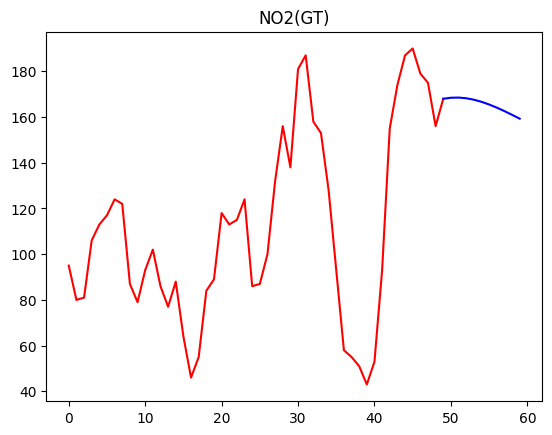

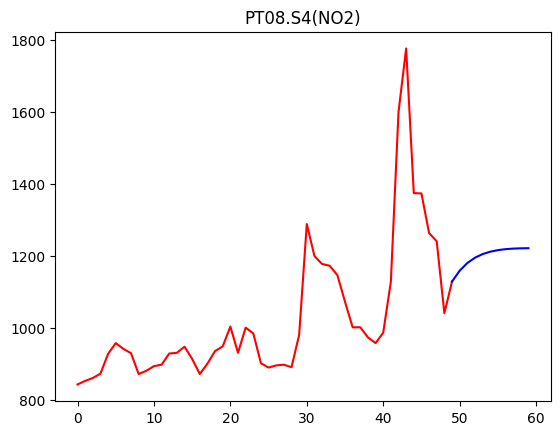

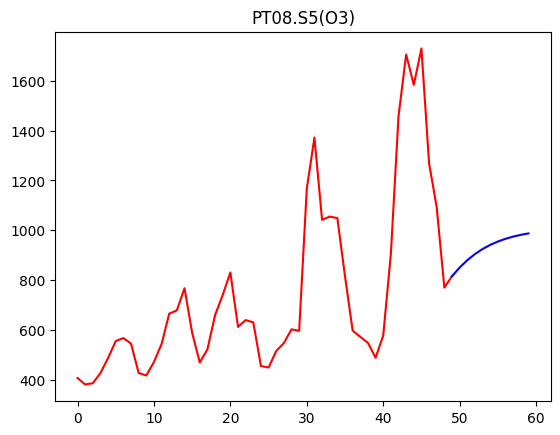

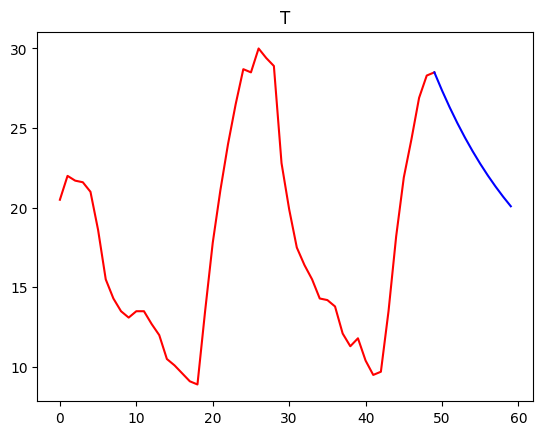

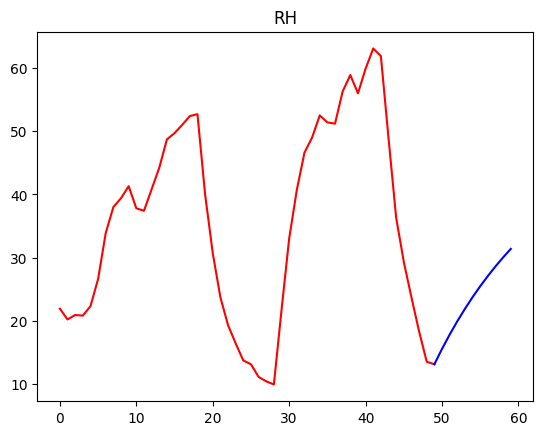

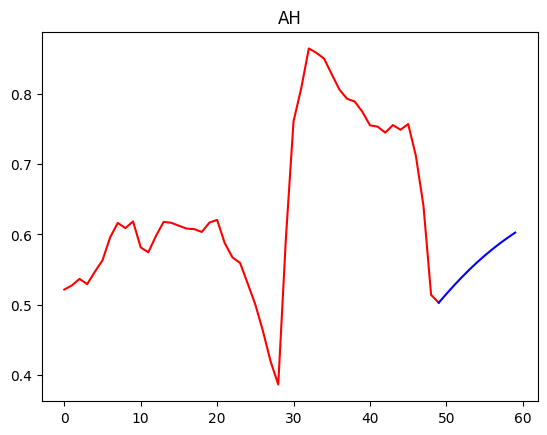

In [10]:
for i in range(len(cols)):
  plt.title(cols[i])
  data_plotted = list(data[cols[i]][-50:])
  predicted_plot = []
  for j in range(num_steps_forecast):
    predicted_plot.append(yhat[j][i])
  plt.plot(list(range(50)),data_plotted, "r-")
  plt.plot(list(range(49,50+num_steps_forecast)),[data_plotted[-1]]+predicted_plot,color='blue')
  plt.pause(0.0001)